# `STARSKØPE`



**Building a Cyberoptic Neural Network Telescope for Astrophysical Object Classification**

> Flatiron School Capstone Project
* `Author: Ru Keïn`
* `Instructor: James Irving PhD`
* `Data Science Full-Time Program`
* `Blog post URL:` http://www.hakkeray.com/datascience/2020/03/22/planetX-hunter-classification-algorithms.html
* `Non-Technical Presentation`: Datascience-CAPSTONE-starskope.pdf

    Note: this project is divided into 3 notebooks:

    starskøpe I : Keras Neural Network Model (this notebook)
    starskøpe II: Computer Vision/Restricted Boltzmann Machines for Spectographs
    starskøpe III: CV/RBMs for Fourier Transformed Spectographs

# Mission Brief

## ABSTRACT

**Questions**
Can a transiting exoplanet be detected strictly by analyzing the raw flux values of a given star? What kind of normalization, de-noising, and/or unit conversion is necessary in order for the analysis to be accurate? How much signal-to-noise ratio is too much? That is, if the classes are highly imbalanced, for instance only a few planets can be confirmed out of thousands of stars, does the imbalance make for an unreliable machine learning model?

**MODEL 1**
To answer the above questions, I started the analysis with a labeled timeseries dataset from Kaggle posted by NASA for K2's campaign 3 observations in which only 42 confirmed exoplanets are detected in a set of over 5,000 stars. This data is labeled and therefore primed for machine learning, however it has no units, and while it is a timeseries, the actual timestamps are not included. If we compare this to the type of data available on the MAST website where the original K2 data and other space telescope observations are housed, there is a significant amount of information about the target stars that is missing and typically quite useful in terms of modeling and analysis for the purpose of detecting exoplanets. 

**RESULTS**
Using the Keras API to train a neural network, I was able to identify with 88% accuracy the handful of stars that have an exoplanet orbiting around them. 

**RECOMMENDATIONS**
While it is possible to create a fairly accurate model for detecting exoplanets using the raw flux values of an imbalanced data set (imbalanced meaning only a few positive examples in a sea of negatives) - it is clear that important information is misclassified. When it comes to astrophysics, we need to be much more accurate than this, and we need to feel like the model is fully reliable. I cannot conclude that this model is adequately reliable for performing an accurate analysis on this type of data.

My recommendations are the following:

   1. Use datasets from the MAST website (via API) to incorporate other calculations of the star's properties as features to be used for classification algorithms. Furthermore, attempt other types of transformations and normalizations on the data before running the model - for instance, apply a Fourier transform.

   2. Combine data from multiple campaigns and perhaps even multiple telescopes (for instance, matching sky coordinates and time intervals between K2, Kepler, and TESS for a batch of stars that have overlapping observations - this would be critical for finding transit periods that are longer than the campaigns of a single telecope's observation period).

   3. Explore using computer vision on not only the Full Frame images we can collect from telescopes like TESS, but also on spectographs of the flux values themselves. The beauty of machine learning is our ability to rely on the computer to pick up very small nuances in differences that we ourselves cannot see with our own eyes. 
   
   4. Explore using autoencoded machine learning algorithms with Restricted Boltzmann Machines - this type of model has proven to be incredibly effective in the image analysis of handwriting as we've seen applied the MNIST dataset - let's find out if the same is true for images of stars, be they the Full Frame Images or spectographs.

**FUTURE WORK**
To continue this project, I'll take another approach for detecting exoplanets using computer vision to analyze images of spectographs of this same star flux data set. Please go to the notebook `[starskøpe-2]` to see how I use a Restricted Boltzmann Machines neural network model to classify stars as exoplanet hosts using spectograph images of the flux values to find transiting exoplanets. Following this, I will apply the same algorithm to spectographs of Fourier transformed data, as you will see in `[starskøpe-3]`. 

Additional future work following this project will be to develop my "cyberoptic artificial telescope" as a machine learning driven application that any astrophysicist can use to look at a single or collection of stars and have the model classify them according not only to exoplanet predictions, but also predict what type of star it is, and other key properties that would be of interest for astrophysical science applications.


# Obtain

Begin by importing libraries and code packages for basic analysis, as well as the kaggle dataset.

In [1]:
# Import code packages and libraries
import numpy as np
import pandas as pd
import matplotlib as mpl
%matplotlib inline
from matplotlib.colors import LogNorm

import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt
plt.style.use('seaborn-bright')
 

font_dict={'family':'"Titillium Web", monospace','size':16}
mpl.rc('font',**font_dict)


#ignore pink warnings
import warnings
warnings.filterwarnings('ignore')
# Allow for large # columns
pd.set_option('display.max_columns', 0)
# pd.set_option('display.max_rows','')

Import dataset which has already been split into train and test sets, `exoTrain.csv.zip` and `exoTest.csv.zip` (I compressed them from their original csv format since the training set is > 240 MB so we'll to unzip them).

In [2]:
import os, glob, sys

home = os.path.abspath(os.curdir)

os.listdir(home)

['Datascience-CAPSTONE-starskope.pdf',
 '.DS_Store',
 'LICENSE',
 'Icon\r',
 'starskøpe-2.ipynb',
 '288_planetbleed1600.jpeg',
 'README.md',
 '.gitignore',
 'starskøpe.ipynb',
 '_config.yml',
 '.ipynb_checkpoints',
 '.git',
 'data']

In [3]:
# %cd ../
%cd data
%ls

/Users/hakkeray/CODE/DATASCIENCE/BOOTCAMP/CAPSTONE/starskope/data
Icon?                                 exoTest.csv.zip
__MACOSX/                             exoTrain.csv
cumulative.csv                        exoTrain.csv.zip
emissionspec_2020.01.30_19.43.11.csv  oec.csv
exoTableDraw.R                        transitspec_2020.01.30_19.38.06.csv
exoTest.csv


In [4]:
# uncomment below if you need to unzip the data files
# !unzip -q 'exoTrain.csv.zip'
# !unzip -q 'exoTest.csv.zip'
# %ls

In [5]:
train = pd.read_csv('exoTrain.csv')
test = pd.read_csv('exoTest.csv')

In [6]:
# cd backto home / root directory
%cd ../

/Users/hakkeray/CODE/DATASCIENCE/BOOTCAMP/CAPSTONE/starskope


# Scrub

In [7]:
display(train.head(), test.head())

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,FLUX.10,FLUX.11,FLUX.12,FLUX.13,FLUX.14,FLUX.15,FLUX.16,FLUX.17,FLUX.18,FLUX.19,FLUX.20,FLUX.21,FLUX.22,FLUX.23,FLUX.24,FLUX.25,FLUX.26,FLUX.27,FLUX.28,FLUX.29,FLUX.30,FLUX.31,FLUX.32,FLUX.33,FLUX.34,FLUX.35,FLUX.36,...,FLUX.3161,FLUX.3162,FLUX.3163,FLUX.3164,FLUX.3165,FLUX.3166,FLUX.3167,FLUX.3168,FLUX.3169,FLUX.3170,FLUX.3171,FLUX.3172,FLUX.3173,FLUX.3174,FLUX.3175,FLUX.3176,FLUX.3177,FLUX.3178,FLUX.3179,FLUX.3180,FLUX.3181,FLUX.3182,FLUX.3183,FLUX.3184,FLUX.3185,FLUX.3186,FLUX.3187,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,-160.17,-207.47,-154.88,-173.71,-146.56,-120.26,-102.85,-98.71,-48.42,-86.57,-0.84,-25.85,-67.39,-36.55,-87.01,-97.72,-131.59,-134.80,-186.97,-244.32,-225.76,-229.60,-253.48,-145.74,-145.74,30.47,-173.39,...,37.40,-81.13,-20.10,-30.34,-320.48,-320.48,-287.72,-351.25,-70.07,-194.34,-106.47,-14.80,63.13,130.03,76.43,131.90,-193.16,-193.16,-89.26,-17.56,-17.31,125.62,68.87,100.01,-9.60,-25.39,-16.51,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,2,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,-73.38,-86.51,-74.97,-73.15,-86.13,-76.57,-61.27,-37.23,-48.53,-30.96,-8.14,-5.54,15.79,45.71,10.61,40.66,16.70,15.18,11.98,-203.70,19.13,19.13,19.13,19.13,19.13,17.02,-8.50,...,20.46,-1.47,-0.40,27.80,-58.20,-58.20,-72.04,-58.01,-30.92,-13.42,-13.98,-5.43,8.71,1.80,36.59,-9.80,-19.53,-19.53,-24.32,-23.88,-33.07,-9.03,3.75,11.61,-12.66,-5.69,12.53,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,2,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,484.39,469.66,462.30,492.23,441.20,483.17,481.28,535.31,554.34,562.80,540.14,576.34,551.67,556.69,550.86,577.33,562.08,577.97,530.67,553.27,538.33,527.17,532.50,273.66,273.66,292.39,298.44,...,-89.61,-69.17,-86.47,-140.91,-84.20,-84.20,-89.09,-55.44,-61.05,-29.17,-63.80,-57.61,2.70,-31.25,-47.09,-6.53,14.00,14.00,-25.05,-34.98,-32.08,-17.06,-27.77,7.86,-70.77,-64.44,-83.83,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67
3,2,326.52,347.39,302.35,298.13,317.74,312.70,322.33,311.31,312.42,323.33,311.14,326.19,313.11,313.89,317.96,330.92,341.10,360.58,370.29,369.71,339.00,336.24,319.31,321.56,308.02,296.82,279.34,275.78,289.67,281.33,285.37,281.87,88.75,88.75,67.71,74.46,...,-25.14,-13.43,-14.74,2.24,-31.07,-31.07,-50.27,-39.22,-51.33,-18.53,-1.99,10.43,-1.97,-15.32,-23.38,-27.71,-36.12,-36.12,-15.65,6.63,10.66,-8.57,-8.29,-21.90,-25.80,-29.86,7.42,5.71,-3.73,-3.73,30.05,20.03,-12.67,-8.77,-17.31,-17.35,13.98
4,2,-1107.21,-1112.59,-1118.95,-1095.10,-1057.55,-1034.48,-998.34,-1022.71,-989.57,-970.88,-933.30,-889.49,-888.66,-853.95,-800.91,-754.48,-717.24,-649.34,-605.71,-575.62,-526.37,-490.12,-458.73,-447.76,-419.54,-410.76,-404.10,-425.38,-397.29,-412.73,-446.49,-413.46,-1006.21,-1006.21,-973.29,-986.01,...,-604.16,-668.26,-742.18,-820.55,-874.76,-874.76,-853.68,-808.62,-777.88,-712.62,-694.01,-655.74,-599.74,-617.30,-602.98,-539.29,-672.71,-672.71,-594.49,-597.60,-560.77,-501.95,-461.62,-468.59,-513.24,-504.70,-521.95,-594.37,-401.66,-401.66,-357.24,-443.76,-438.54,-399.71,-384.65,-411.79,-510.54


,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,FLUX.10,FLUX.11,FLUX.12,FLUX.13,FLUX.14,FLUX.15,FLUX.16,FLUX.17,FLUX.18,FLUX.19,FLUX.20,FLUX.21,FLUX.22,FLUX.23,FLUX.24,FLUX.25,FLUX.26,FLUX.27,FLUX.28,FLUX.29,FLUX.30,FLUX.31,FLUX.32,FLUX.33,FLUX.34,FLUX.35,FLUX.36,...,FLUX.3161,FLUX.3162,FLUX.3163,FLUX.3164,FLUX.3165,FLUX.3166,FLUX.3167,FLUX.3168,FLUX.3169,FLUX.3170,FLUX.3171,FLUX.3172,FLUX.3173,FLUX.3174,FLUX.3175,FLUX.3176,FLUX.3177,FLUX.3178,FLUX.3179,FLUX.3180,FLUX.3181,FLUX.3182,FLUX.3183,FLUX.3184,FLUX.3185,FLUX.3186,FLUX.3187,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2,119.88,100.21,86.46,48.68,46.12,39.39,18.57,6.98,6.63,-21.97,-23.17,-29.26,-33.99,-6.25,-28.12,-27.24,-32.28,-12.29,-16.57,-23.86,-5.69,9.24,35.52,81.20,116.49,133.99,148.97,174.15,187.77,215.30,246.80,-56.68,-56.68,-56.68,-52.05,-31.52,...,-23.53,2.54,30.21,38.87,-22.86,-22.86,-4.37,2.27,-16.27,-30.84,-7.21,-4.27,13.60,15.62,31.96,49.89,86.93,86.93,42.99,48.76,22.82,32.79,30.76,14.55,10.92,22.68,5.91,14.52,19.29,14.44,-1.62,13.33,45.50,31.93,35.78,269.43,57.72
1,2,5736.59,5699.98,5717.16,5692.73,5663.83,5631.16,5626.39,5569.47,5550.44,5458.80,5329.39,5191.38,5031.39,4769.89,4419.66,4218.92,3924.73,3605.30,3326.55,3021.20,2800.61,2474.48,2258.33,1951.69,1749.86,1585.38,1575.48,1568.41,1661.08,1977.33,2425.62,2889.61,3847.64,3847.64,3741.20,3453.47,...,-3636.05,-2324.27,-2688.55,-2813.66,-586.22,-586.22,-756.80,-1090.23,-1388.61,-1745.36,-2015.28,-2359.06,-2516.66,-2699.31,-2777.55,-2732.97,1167.39,1167.39,1368.89,1434.80,1360.75,1148.44,1117.67,714.86,419.02,57.06,-175.66,-581.91,-984.09,-1230.89,-1600.45,-1824.53,-2061.17,-2265.98,-2366.19,-2294.86,-2034.72
2,2,844.48,817.49,770.07,675.01,605.52,499.45,440.77,362.95,207.27,150.46,85.49,-20.12,-35.88,-65.59,-15.12,16.60,-25.70,61.88,53.18,64.32,72.38,100.35,67.26,14.71,-16.41,-147.46,-231.27,-320.29,-407.82,-450.48,-146.99,-146.99,-146.99,-146.99,-166.30,-139.90,...,-56.48,-74.60,-115.18,-8.91,-37.59,-37.59,-37.43,-104.23,-101.45,-107.35,-109.82,-126.27,-170.32,-117.85,-32.30,-70.18,314.29,314.29,314.29,149.71,54.60,12.60,-133.68,-78.16,-52.30,-8.55,-19.73,17.82,-51.66,-48.29,-59.99,-82.10,-174.54,-95.23,-162.68,-36.79,30.63
3,2,-826.00,-827.31,-846.12,-836.03,-745.50,-784.69,-791.22,-746.50,-709.53,-679.56,-706.03,-720.56,-631.12,-659.16,-672.03,-665.06,-667.94,-660.84,-672.75,-644.91,-680.53,-620.50,-570.34,-530.00,-537.88,-578.38,-532.34,-532.38,-491.03,-485.03,-427.19,-380.84,-329.50,-286.91,-283.81,-298.19,...,-1286.59,-1286.59,-1286.59,-1286.59,-1286.59,-1286.59,-14.94,64.09,8.38,45.31,100.72,91.53,46.69,20.34,30.94,-36.81,-33.28,-69.62,-208.00,-280.28,-340.41,-337.41,-268.03,-245.00,-230.62,-129.59,-35.47,122.34,93.03,93.03,68.81,9.81,20.75,20.25,-120.81,-257.56,-215.41
4,2,-39.57,-15.88,-9.16,-6.37,-16.13,-24.05,-0.90,-45.20,-5.04,14.62,-19.52,-11.43,-49.80,25.84,11.62,3.18,-9.59,14.49,8.82,32.32,-28.90,-28.90,-14.09,-30.87,-18.99,-38.60,-27.79,9.65,29.60,7.88,42.87,27.59,27.05,20.26,29.48,9.71,...,-56.45,-41.71,-34.13,-43.12,-53.63,-53.63,-53.63,-24.29,22.29,25.18,1.84,-22.29,-26.43,-12.12,-33.05,-21.66,-228.32,-228.32,-228.32,-187.35,-166.23,-115.54,-50.18,-37.96,-22.37,-4.74,-35.82,-37.87,-61.85,-27.15,-21.18,-33.76,-85.34,-81.46,-61.98,-69.34,-17.84


In [8]:
# Check the value counts - notice there are a total of only 42 stars that are labeled "2"
# which means there is a confirmed exoplanet. 37 in the training set, 5 in the test set.
display(train['LABEL'].value_counts(),test['LABEL'].value_counts())

1    5050
2      37
Name: LABEL, dtype: int64

1    565
2      5
Name: LABEL, dtype: int64

Check for nulls:

In [9]:
train.isna().sum().value_counts()

0    3198
dtype: int64

In [10]:
test.isna().sum().value_counts()

0    3198
dtype: int64

In [11]:
## Compare: Exoplanet vs Non-exoplanet Host Stars

# look at the first Star in the dataset (label = 2 means confirmed host of exoplanet)
starA = train.iloc[0, :]
starA.head()

LABEL      2.00
FLUX.1    93.85
FLUX.2    83.81
FLUX.3    20.10
FLUX.4   -26.98
Name: 0, dtype: float64

In [12]:
# non-exoplanet host star in last row of index (5086 or -1)
starB = train.iloc[-1, :]
starB.head()

LABEL       1.00
FLUX.1    323.28
FLUX.2    306.36
FLUX.3    293.16
FLUX.4    287.67
Name: 5086, dtype: float64

# Explore

In [13]:
def starplots(flux_signal, figsize=(15,5)):
    
    # get label
    label = flux_signal['LABEL']
    if label == 2:
        title = "Star flux signal showing Threshold Crossing Event"
    else:
        title = "Star Flux with no sign of Threshold Crossing Event"
    
    # Scatter Plot 
    plt.figure(figsize=figsize)
    plt.scatter(pd.Series([i for i in range(1, len(flux_signal))]), flux_signal[1:])
    plt.ylabel('Flux')
    plt.xlabel('Time')
    plt.title(title)
    plt.show();

    # Line Plot
    plt.figure(figsize=figsize)
    plt.plot(pd.Series([i for i in range(1, len(flux_signal))]), flux_signal[1:])
    plt.ylabel('Flux')
    plt.xlabel('Time')
    plt.title(title)
    plt.show();

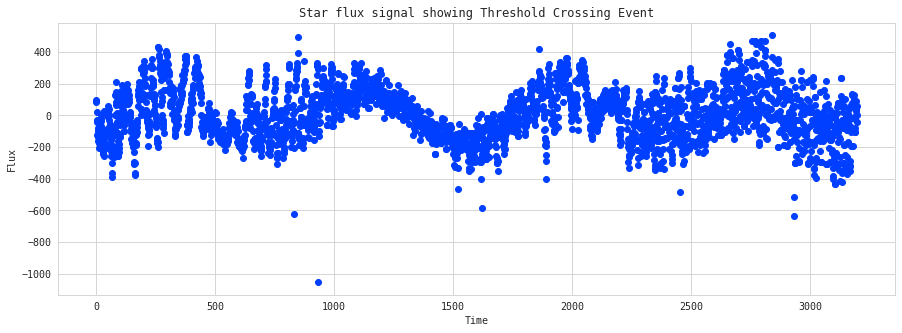

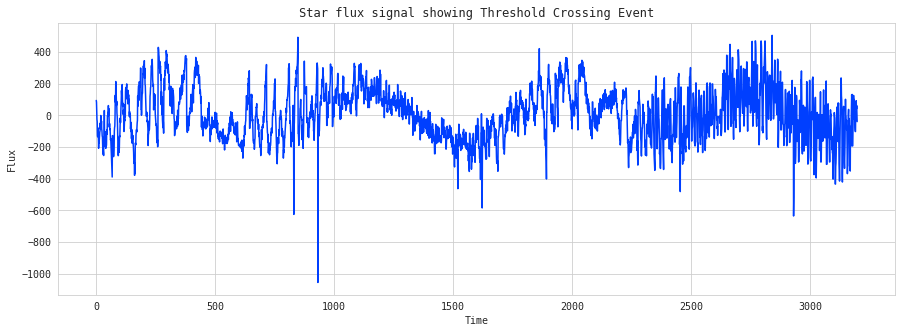

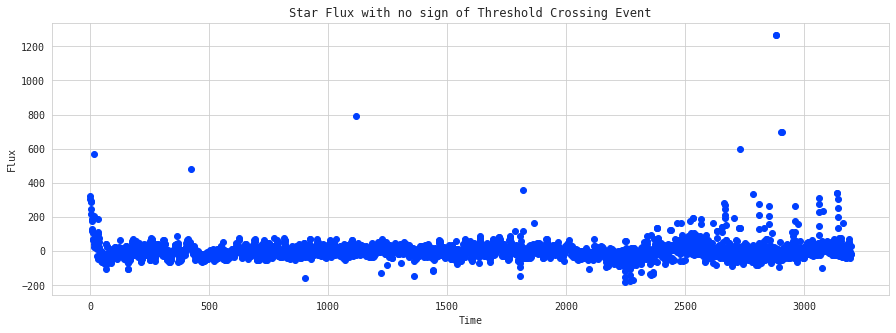

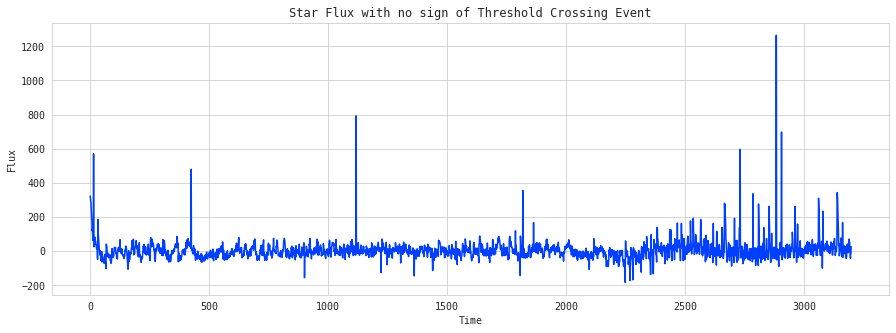

In [14]:
starplots(starA)
starplots(starB)

# Model 1 - Keras Neural Network

In [15]:
# import additional libraries from sklearn
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score
from scipy.ndimage.filters import uniform_filter1d
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import random

In [16]:
# !pip install keras
# !pip install tensorflow

In [16]:
# import additional libraries for keras
import keras
from keras.utils.np_utils import to_categorical

from keras.preprocessing.text import Tokenizer
from keras import models, layers, optimizers


from keras.models import Sequential, Model
from keras.layers import Conv1D, MaxPool1D, Dense, Dropout, Flatten, \
BatchNormalization, Input, concatenate, Activation
from keras.optimizers import Adam

Using TensorFlow backend.


## Train-Test Split

In [17]:
# Using Numpy instead of Pandas to create the 1-dimensional arrays
def numpy_train_test_split(data_folder, train_set, test_set):
    import numpy as np
    
    train = np.loadtxt(data_folder+train_set, skiprows=1, delimiter=',')
    x_train = train[:, 1:]
    
    
    y_train = train[:, 0, np.newaxis] - 1.
    
    test = np.loadtxt(data_folder+test_set, skiprows=1, delimiter=',')
    x_test = test[:, 1:]
    y_test = test[:, 0, np.newaxis] - 1.
    
    del train,test
    
    return x_train, y_train, x_test, y_test

In [18]:
x_train, y_train, x_test, y_test = numpy_train_test_split(data_folder='data/', train_set='exoTrain.csv', 
                 test_set='exoTest.csv')

In [21]:
def zero_scaler(xtrain, xtest, fsize=200):
    
    import numpy as np
    #Scale each observation to zero mean and unit variance.
    x_train = ((xtrain - np.mean(xtrain, axis=1).reshape(-1,1)) / 
           np.std(xtrain, axis=1).reshape(-1,1))
    
    x_test = ((xtest - np.mean(xtest, axis=1).reshape(-1,1)) / 
              np.std(xtest, axis=1).reshape(-1,1))
 
    return x_train, x_test

In [22]:
x_train,x_test = zero_scaler(x_train, x_test)

Add an input corresponding to the running average over 200 time steps. This helps the net ignore high frequency noise and instead look at non-local information.

In [24]:
def time_stepper(xtrain,xtest, time_steps=200):
    import numpy as np
    from scipy.ndimage.filters import uniform_filter1d
    
    x_train = np.stack([xtrain, uniform_filter1d(xtrain, axis=1, size=time_steps)], axis=2)
    x_test = np.stack([xtest, uniform_filter1d(xtest, axis=1, size=time_steps)], axis=2)
    
    return x_train, x_test

In [25]:
x_train, x_test = time_stepper(x_train, x_test, time_steps=200)

In [26]:
x_train.shape

(5087, 3197, 2)

In [27]:
x_test.shape

(570, 3197, 2)

## Train Model

Adding the layers one at a time:

Each 1D convolutional layers corresponds to a local filter, and then a pooling layer reduces the data length by approximately a factor 4. At the end, there are two dense layers, just as we would in a typical image classifier. Batch normalization layers speed up convergence.

In [3]:
# TODO: Explain tactical decisions 

In [54]:
model = Sequential()
model.add(Conv1D(filters=8, kernel_size=11, activation='relu', input_shape=x_train.shape[1:]))
model.add(MaxPool1D(strides=4))
model.add(BatchNormalization())
model.add(Conv1D(filters=16, kernel_size=11, activation='relu'))
model.add(MaxPool1D(strides=4))
model.add(BatchNormalization())
model.add(Conv1D(filters=32, kernel_size=11, activation='relu'))
model.add(MaxPool1D(strides=4))
model.add(BatchNormalization())
model.add(Conv1D(filters=64, kernel_size=11, activation='relu'))
model.add(MaxPool1D(strides=4))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

The data here is extremely unbalanced, with only a few positive examples. To correct for this, we need to use the positive examples a lot more often, so that the network sees 50% of each over each batches. 

We also want to generate new examples by rotating them randomly each time. This is called augmentation and is similar to when we rotate/shift examples in image classification.

In [55]:
def batch_generator(x_train, y_train, batch_size=32):
    """
    Gives equal number of positive and negative samples, and rotates them randomly in time
    """
    half_batch = batch_size // 2
    x_batch = np.empty((batch_size, x_train.shape[1], x_train.shape[2]), dtype='float32')
    y_batch = np.empty((batch_size, y_train.shape[1]), dtype='float32')
    
    yes_idx = np.where(y_train[:,0] == 1.)[0]
    non_idx = np.where(y_train[:,0] == 0.)[0]
    
    while True:
        np.random.shuffle(yes_idx)
        np.random.shuffle(non_idx)
    
        x_batch[:half_batch] = x_train[yes_idx[:half_batch]]
        x_batch[half_batch:] = x_train[non_idx[half_batch:batch_size]]
        y_batch[:half_batch] = y_train[yes_idx[:half_batch]]
        y_batch[half_batch:] = y_train[non_idx[half_batch:batch_size]]
    
        for i in range(batch_size):
            sz = np.random.randint(x_batch.shape[1])
            x_batch[i] = np.roll(x_batch[i], sz, axis = 0)
     
        yield x_batch, y_batch

The hyperparameters here are chosen to finish training within the Kernel, rather than to get optimal results. On a GPU, we could probably use a smaller learning rate, and SGD instead of Adam. 

In [ ]:
# TODO: Functionize making the model

In [56]:
#Start with a slightly lower learning rate, to ensure convergence
model.compile(optimizer=Adam(1e-5), loss = 'binary_crossentropy', metrics=['accuracy'])
hist = model.fit_generator(batch_generator(x_train, y_train, 32), 
                           validation_data=(x_test, y_test), 
                           verbose=0, epochs=5,
                           steps_per_epoch=x_train.shape[1]//32)

In [2]:
# TODO: model.summary

In [57]:
#Then speed things up a little
model.compile(optimizer=Adam(4e-5), loss = 'binary_crossentropy', metrics=['accuracy'])
hist = model.fit_generator(batch_generator(x_train, y_train, 32), 
                           validation_data=(x_test, y_test), 
                           verbose=2, epochs=40,
                           steps_per_epoch=x_train.shape[1]//32)

Epoch 1/40
 - 7s - loss: 0.7038 - accuracy: 0.5574 - val_loss: 0.6824 - val_accuracy: 0.5772
Epoch 2/40
 - 6s - loss: 0.6844 - accuracy: 0.5852 - val_loss: 0.6550 - val_accuracy: 0.6246
Epoch 3/40
 - 6s - loss: 0.6603 - accuracy: 0.6114 - val_loss: 0.6253 - val_accuracy: 0.6719
Epoch 4/40
 - 6s - loss: 0.6505 - accuracy: 0.6285 - val_loss: 0.6083 - val_accuracy: 0.6965
Epoch 5/40
 - 6s - loss: 0.6312 - accuracy: 0.6297 - val_loss: 0.5929 - val_accuracy: 0.7263
Epoch 6/40
 - 6s - loss: 0.6282 - accuracy: 0.6496 - val_loss: 0.5741 - val_accuracy: 0.7351
Epoch 7/40
 - 6s - loss: 0.6165 - accuracy: 0.6645 - val_loss: 0.5552 - val_accuracy: 0.7526
Epoch 8/40
 - 6s - loss: 0.6007 - accuracy: 0.6698 - val_loss: 0.5482 - val_accuracy: 0.7544
Epoch 9/40
 - 6s - loss: 0.5991 - accuracy: 0.6730 - val_loss: 0.5287 - val_accuracy: 0.7649
Epoch 10/40
 - 6s - loss: 0.5978 - accuracy: 0.6809 - val_loss: 0.5215 - val_accuracy: 0.7614
Epoch 11/40
 - 6s - loss: 0.5725 - accuracy: 0.6998 - val_loss: 0.505

In [ ]:
# TODO: model.summary

In [ ]:
# TODO: try changing learning rate: increase 4e-3


# Interpret Results

In [ ]:
# TODO: Confusion Matrices

Look at convergence:

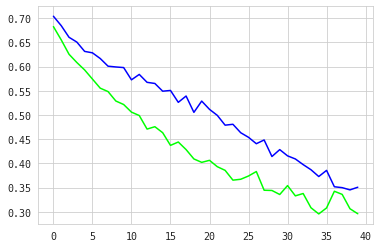

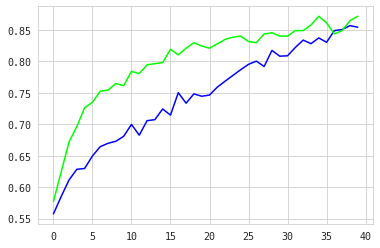

In [70]:
plt.plot(hist.history['loss'], color='blue')
plt.plot(hist.history['val_loss'], color='lime')
plt.show()
plt.plot(hist.history['accuracy'], color='blue')
plt.plot(hist.history['val_accuracy'], color='lime')
plt.show()

We then use our trained neural network to classify the test set:

In [63]:
non_idx = np.where(y_test[:,0] == 0.)[0]
yes_idx = np.where(y_test[:,0] == 1.)[0]
y_hat = model.predict(x_test)[:,0]

In [5]:
# TODO: Evaluate model predictions with plots

# scikit learn: predict classes

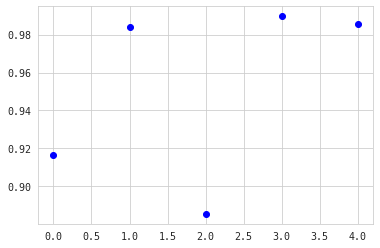

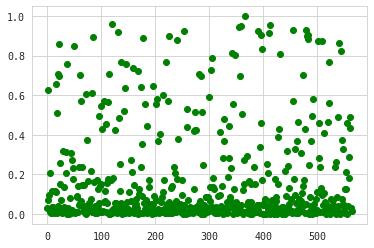

In [72]:
plt.plot([y_hat[i] for i in yes_idx], 'bo')
plt.show()
plt.plot([y_hat[i] for i in non_idx], 'go')
plt.show()

Not all five positive examples all get 0.95-1.00 score. More than half of the negative examples get score close to zero, however a decent proportion of the negatives also received scores closer to 1. 

## Validation

With the help of Sci-kit Learn, we can now choose an optimal cutoff score for classification. 

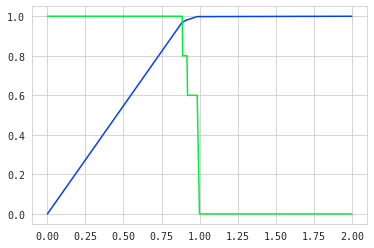

Crossover at 0.89 with specificity 0.97


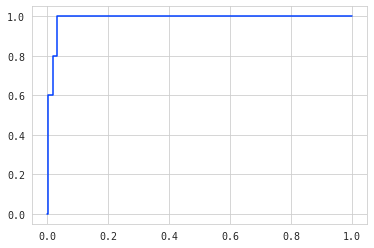

ROC area under curve is 0.99


In [65]:
# TODO functionize
y_true = (y_test[:, 0] + 0.5).astype("int")
fpr, tpr, thresholds = roc_curve(y_true, y_hat)
plt.plot(thresholds, 1.-fpr)
plt.plot(thresholds, tpr)
plt.show()
crossover_index = np.min(np.where(1.-fpr <= tpr))
crossover_cutoff = thresholds[crossover_index]
crossover_specificity = 1.-fpr[crossover_index]
print("Crossover at {0:.2f} with specificity {1:.2f}".format(crossover_cutoff, crossover_specificity))
plt.plot(fpr, tpr)
plt.show()
print("ROC area under curve is {0:.2f}".format(roc_auc_score(y_true, y_hat)))

Let's look at the misclassified data (of which there appears to be quite a few, unfortunately!):

89


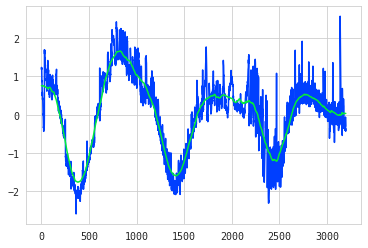

124


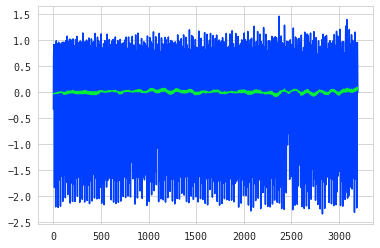

136


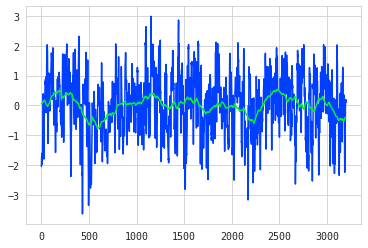

183


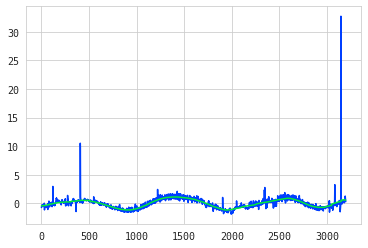

230


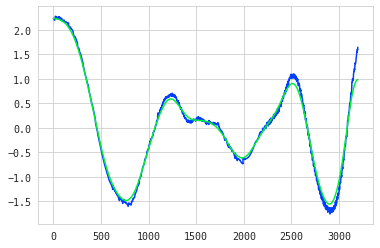

258


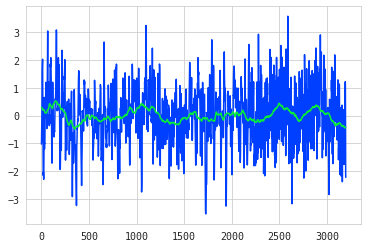

360


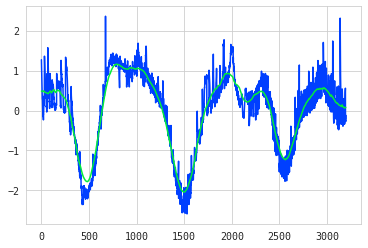

363


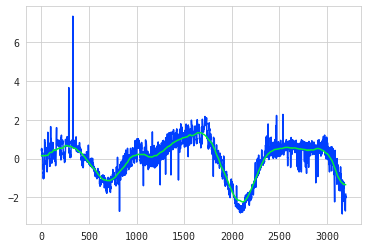

372


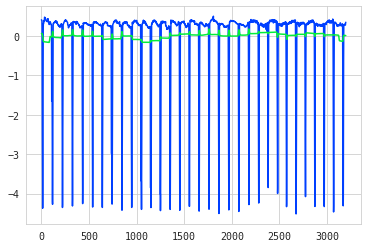

395


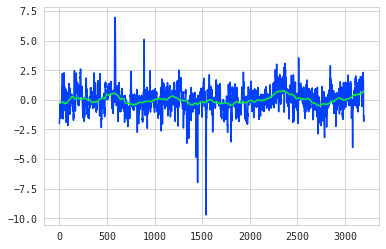

400


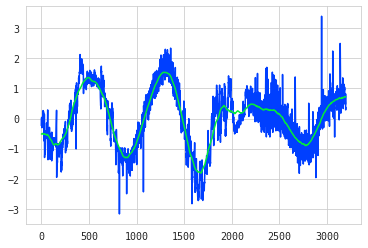

415


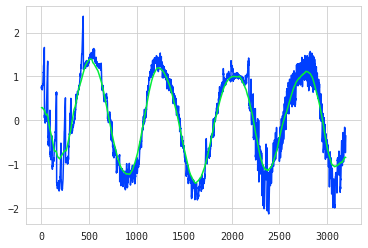

417


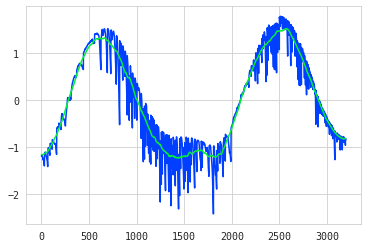

460


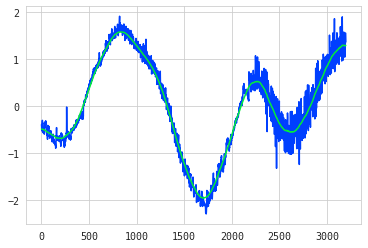

485


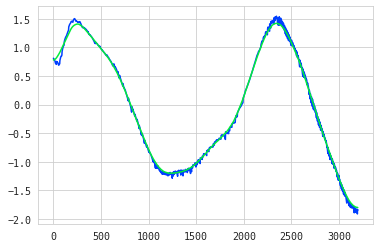

486


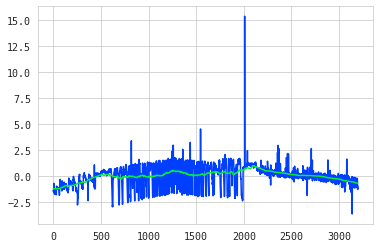

487


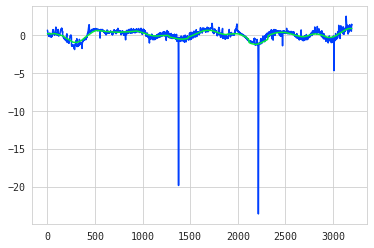

In [66]:
# TODO: Functionize
false_positives = np.where(y_hat * (1. - y_test) > 0.5)[0]
for i in non_idx:
    if y_hat[i] > crossover_cutoff:
        print(i)
        plt.plot(x_test[i])
        plt.show()

# Conclusion

Above, we were able to identify with 88% accuracy the handful of stars that have an exoplanet orbiting around them. 

# Recommendations

While it is possible to create a fairly accurate model for detecting exoplanets using the raw flux values of an imbalanced data set (imbalanced meaning only a few positive examples in a sea of negatives) - it is clear that important information is misclassified. When it comes to astrophysics, we need to be much more accurate than this, and we need to feel like the model is fully reliable. I cannot conclude that this model is adequately reliable for performing an accurate analysis on this type of data.

My recommendations are the following:

   1. Use datasets from the MAST website (via API) to incorporate other calculations of the star's properties as features to be used for classification algorithms. Furthermore, attempt other types of transformations and normalizations on the data before running the model - for instance, apply a Fourier transform.

   2. Combine data from multiple campaigns and perhaps even multiple telescopes (for instance, matching sky coordinates and time intervals between K2, Kepler, and TESS for a batch of stars that have overlapping observations - this would be critical for finding transit periods that are longer than the campaigns of a single telecope's observation period).

   3. Explore using computer vision on not only the Full Frame images we can collect from telescopes like TESS, but also on spectographs of the flux values themselves. The beauty of machine learning is our ability to rely on the computer to pick up very small nuances in differences that we ourselves cannot see with our own eyes. 
   
   4. Explore using autoencoded machine learning algorithms with Restricted Boltzmann Machines - this type of model has proven to be incredibly effective in the image analysis of handwriting as we've seen applied the MNIST dataset - let's find out if the same is true for images of stars, be they the Full Frame Images or spectographs.

# Future Work

To continue this project, I'll take another approach for detecting exoplanets using computer vision to analyze images of spectographs of this same star flux data set. Please go to the notebook `[starskøpe-2]` to see how I use a Restricted Boltzmann Machines neural network model to classify stars as exoplanet hosts using spectograph images of the flux values to find transiting exoplanets. Following this, I will apply the same algorithm to spectographs of Fourier transformed data, as you will see in `[starskøpe-3]`. 

Additional future work following this project will be to develop my "cyberoptic artificial telescope" as a machine learning driven application that any astrophysicist can use to look at a single or collection of stars and have the model classify them according not only to exoplanet predictions, but also predict what type of star it is, and other key properties that would be of interest for astrophysical science applications.
